# NYPD Allegations
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the outcome of an allegation (might need to feature engineer your output column).
    * Predict the complainant or officer ethnicity.
    * Predict the amount of time between the month received vs month closed (difference of the two columns).
    * Predict the rank of the officer.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings

### Introduction
Using the same NYPD data we did in project 3 we decided to further investigate the board disposition variable and build a model to solve the prediction problem: Based on the age, ethnicity, and gender will the outcome of the case be guilty or not guilty?

To do this we cleaned the board disposition column by creating a helper function that accepted a board disposition value and determined whether the defendant was guilty or not guilty, and replaced the value of board disposition accordingly. To predict our target variable we chose to keep our focus on the same three key features (age, gender, and ethnicity) as we did previously, for both the officer and complainant for each complaint. We cleaned these columns by replacing missing or uninformative values with NaN and then dropped all rows containing null values from our dataset. Since we are truly only concerned about the effects of these features on the verdict we dropped the unrelated data from the dataset as well. 

We chose to use a DecisionTreeClassifier to construct our model as we found this to be the most appropriate tool given we are trying to predict a label rather than a quantity. We utilized the columns complainant_gender, complainant_age, complainant_ethnicity, mos_gender, mos_age, and mos_ethnicity to form the features we used for our baseline and final models. The board_disposition , i.e. the result of each complaint, was our resultant data. 

### Baseline Model
To predict the complaint result using a classification model, we chose the features that we felt were most impactful to the problem at hand- the ethnicities, genders, and ages of the complainants as well as the officers. These features corresponded to six columns in our data. 

We first split each dataset into a dedicated train set and a test set using the sk-learn function train_test_split(), deciding to utilize 70% of our data for the training set, and 30% for the testing set. Because our data requires feature engineering, we created a helper function to create the pipeline, called bl_pipeline. 


While creating our baseline pipeline, we realized that our six features are not homogenous, i.e. four were categorical, and two were quantitative. Because of this, we had to encode the categorical features before being able to use them in our baseline and final model(s). We decided to encode the four categorical features ("mos_gender", "mos_ethnicity", "complainant_gender", complainant_ethnicity") using one-hot encoding. We chose one-hot encoding over other encodings because we are dealing with nominal data, so other encoders are rendered useless (such as binary encoding, ordinal encoding, etc). While we still had the option of using FeatureHasher, or other encoders, we chose one-hot because it is designed specifically for nominal categorical data. Hence, we utilized ColumnTransformer to encode the categorical features using the OneHotEncoder, specifying those four columns to be encoded. The remaining [two] columns were passed through as is, as they are already quantitative data. 


We did some research regarding which classification algorithm to use from the various options that sk-learn provides. We had to come to a decision between a RandomForestClassifier and the DecisionTreeClassifier. We actually ran both models and realized that the random forest model actually overfit our training data. So, DecisionTreeClassifier seemed to be our best option, and we had quite a large sample size (> 10K data points). We additionally knew that our data doesn't have a linear fit. So, we built a pipeline using the preprocessed [and transformed] data using a DecisionTreeClassifier.


**Note: Both feature engineering and creation of the pipeline is done inside our helper function.*


We then call our helper function, hence creating a pipeline using our entire dataset. We fit our model using our pipeline, and judge our results using an evaluation metric- the score, which for our classification is the accuracy metric. We ended up with the following results after "scoring" our training and testing set:

Train set score = 0.8537478117871731\
Test set score = 0.7063118811881188


Clearly, our train set score was higher than our test set score, so our data is being overfit by our DecisionTreeClassifier model. We then attempted to reduce our overfitting in our final model by transforming our data that we use to train and test our model. 


### Final Model
In an attempt to increase our testing score (accuracy), we took a multipronged approach. Initially, we plotted a density histogram of the complainant_age_incident and mos_age_incident to better understand how our quantitative data is distributed. We then decided to use the sk-learn library called GridSearchCV to come up with the best parameters; prior to doing so, we perform feature engineering once again. We decided to one-hot encode our categorical data once again, similar to the baseline model. We then decided to use three transformers during the feature engineering process on our quantitative data. 


The first transformer we used was the QuantileTransformer, which modifies our data such that there is somewhat of a normal distribution, while also removing marginal outliers. We used our histograms describing the distribution of our age data (complainants and officers) to decide on the number of quantiles. 


In another attempt at improving our model accuracy, we decided to use the RobustScaler that sk-learn provides. This scaler uses statistical measures, specifically the interquartile range (IQR) and median to center and scale the data. In our case, we use this scaler to center and scale the ages of the complainants and officers; this assists the classifier by also storing the median and IQR to use on later data (during the transform function call). 


Finally, we decided to utilize the StandardScaler to standardize the features (complainant and officer age) by removing the mean and scaling it to unit variance. In other words, the StandardScaler computes the z-score of all the samples (individually), and similar to RobustScaler, stores the median and standard deviation to use on later data (during the transform function call). We use StandardScaler because it ensures that our machine learning estimator (classifier) does not misbehave. This is also critical to deal with features with variances high enough to detract from other features (as per the sk-learn documentation).  


Finally, similar to our baseline model, we created a pipeline via a helper function which included our feature engineering, and fit our model using the finalized pipeline. We scored our final model on our training set and testing set, and had the following scores:

Train set score: 0.7570420667338603\
Test set score: 0.7518564356435643


We noticed that our train set score went down from our baseline model, indicating that we at least improved our model with respect to overfitting. Our test set accuracy went up as well, which suggested that our model and its classifications are improved with respect to the testing set. 

### Fairness Evaluation
To assess the fairness of our model we chose accuracy for our parity measure. To test the accuracy, we created a pipeline using our final model, and fit it using training data including only the rows with male or female complainant_age_genders, as this is what we decided to perform a fairness evaluation on. We come up with a confusion matrix, and find the recall_score for both "guilty" and "not guilty" complaints. 

We found that the recall scores were as follows:

Guilty: 0.009081735620585268\
Not Guilty: 0.9944244014430961

We then developed our null and alternative hypothesis:
Null Hypothesis: Our model is fair, and the accuracy for my male and female subsets is approximately the same. 
Alternative Hypothesis: Our model is not fair, and the accuracy for my female subset is higher than for the male subset. 


We added a prediction column to our data, as well as came up with the score_accuracy for all genders, although we only focus on male and female. Because we had 99.9% of our data in our two subsets (~27/27000 that weren't male or female gender), we felt it was understandable to perform a fairness evaluation on the just those two genders. Finally, we calculate the observed difference of 0.05486190450283812, and perform a permutation test, resulting in a p-value of 0.596. 


From this p-value, we can safely we reject the null hypothesis and conclude that our model is not fair- the accuracy for the female complainants was higher than that of male complainants.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import QuantileTransformer, RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
path = os.path.join("data", "allegations_202007271729.csv")
df = pd.read_csv(path)

In [3]:
df.head(4)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)


In [4]:
for i in df["board_disposition"].unique():
    print(i)

Substantiated (Command Lvl Instructions)
Substantiated (Charges)
Substantiated (Command Discipline A)
Substantiated (Formalized Training)
Unsubstantiated
Exonerated
Substantiated (Command Discipline B)
Substantiated (Instructions)
Substantiated (Command Discipline)
Substantiated (No Recommendations)
Substantiated (MOS Unidentified)


In [5]:
def res_helper(temp):
    if "Unsubstantiated".upper() in temp.upper():
        return "Not Guilty"
    elif "Substantiated".upper() in temp.upper():
        return "Guilty"
    else:
        return "Not Guilty"

df["board_disposition"] = df["board_disposition"].apply(res_helper)

In [6]:
df.head(5)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Guilty
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Guilty
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Guilty
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Guilty
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Guilty


In [7]:
df["complainant_age_incident"] = df["complainant_age_incident"].apply(lambda x: np.NaN if x < 0 else x)
df["complainant_ethnicity"] = df["complainant_ethnicity"].replace({"Unknown": np.NaN, "Refused": np.NaN})
df["complainant_gender"] = df["complainant_gender"].replace({"Not described": np.NaN})
df["mos_gender"] = df["mos_gender"].replace({"M": "Male", "F": "Female"})
df = df.dropna().reset_index(drop = True)

In [8]:
df = df.sample(frac = 1)
data = df[["complainant_gender", "complainant_ethnicity", "complainant_age_incident", "mos_gender", "mos_ethnicity", "mos_age_incident", "board_disposition"]]

In [9]:
data.head()

,complainant_gender,complainant_ethnicity,complainant_age_incident,mos_gender,mos_ethnicity,mos_age_incident,board_disposition
5833,Male,Hispanic,21.0,Male,White,31,Not Guilty
21881,Female,White,61.0,Male,White,35,Not Guilty
19042,Female,Black,38.0,Male,Hispanic,47,Not Guilty
14251,Male,Hispanic,26.0,Male,White,28,Not Guilty
23005,Male,Black,49.0,Male,White,27,Not Guilty


### Baseline Model

In [10]:
X = data.drop("board_disposition", axis = 1)
y = data.board_disposition

In [11]:
X.head(3)

,complainant_gender,complainant_ethnicity,complainant_age_incident,mos_gender,mos_ethnicity,mos_age_incident
5833,Male,Hispanic,21.0,Male,White,31
21881,Female,White,61.0,Male,White,35
19042,Female,Black,38.0,Male,Hispanic,47


In [12]:
y.head(3)

5833     Not Guilty
21881    Not Guilty
19042    Not Guilty
Name: board_disposition, dtype: object

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

In [14]:
def bl_pipeline(temp):
    features = ColumnTransformer(transformers = [("one_hot_code", OneHotEncoder(handle_unknown = 'ignore'), ["complainant_gender", "complainant_ethnicity", "mos_gender", "mos_ethnicity"])], remainder = "passthrough")
    ppln = Pipeline([("Preprocess", features), ("DecisionTreeClassifier", DecisionTreeClassifier())])
    #ppln = Pipeline([("Preprocess", features), ("RandomForestClassifier", RandomForestClassifier())])
    return ppln

caller = data.copy()
bl_ppln = bl_pipeline(caller)

In [15]:
bl_ppln.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('one_hot_code',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['complainant_gender',
                                                   'complainant_ethnicity',
                                                   'mos_gender',
                                                   'mos_

In [16]:
bl_ppln.score(X_train, y_train)

0.8537478117871731

In [17]:
bl_ppln.score(X_test, y_test)

0.7063118811881188

### Final Model

(array([7.35285738e-05, 1.50807105e-02, 3.50069540e-02, 2.37570822e-02,
        1.58932012e-02, 6.82345164e-03, 1.85292006e-03, 4.63230015e-04,
        5.14700016e-05, 7.35285738e-06]),
 array([  0. ,  10.1,  20.2,  30.3,  40.4,  50.5,  60.6,  70.7,  80.8,
         90.9, 101. ]),
 <BarContainer object of 10 artists>)

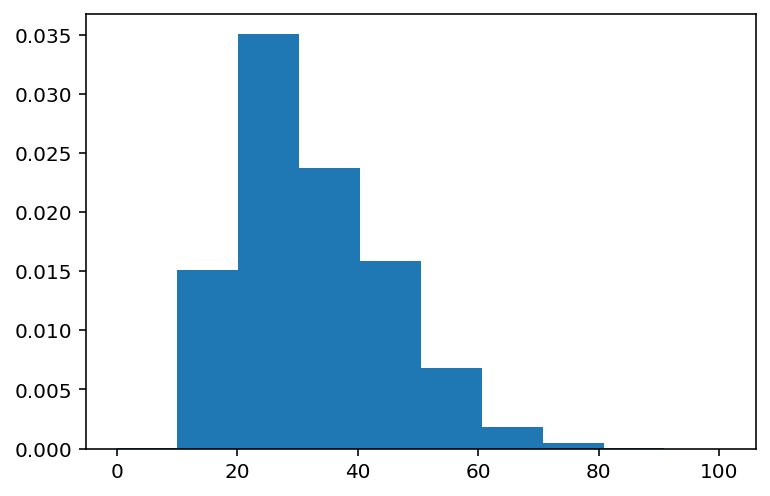

In [18]:
plt.hist(df["complainant_age_incident"], density = True)

(array([0.01516697, 0.05967768, 0.06901778, 0.05430783, 0.03180969,
        0.01603338, 0.00736926, 0.00236121, 0.0005427 , 0.00012377]),
 array([21. , 24.9, 28.8, 32.7, 36.6, 40.5, 44.4, 48.3, 52.2, 56.1, 60. ]),
 <BarContainer object of 10 artists>)

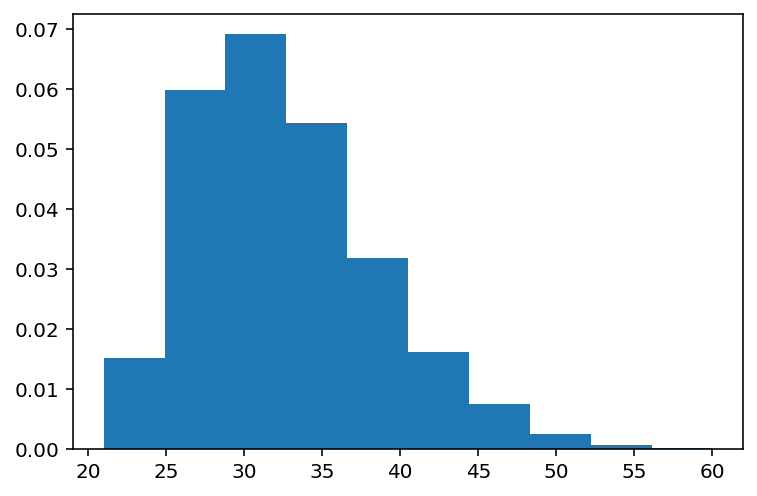

In [19]:
plt.hist(df["mos_age_incident"], density = True)

In [20]:
parameters = {
    'max_depth': [2,3,4,5,7,10,13,15,18,None], 
    'min_samples_split':[2,3,5,7,10,15,20],
    'min_samples_leaf':[2,3,5,7,10,15,20]
}

In [21]:
features = ColumnTransformer(transformers = [("one_hot_code", OneHotEncoder(handle_unknown = 'ignore'), ["complainant_gender", "complainant_ethnicity", "mos_gender", "mos_ethnicity"]), 
                                             ("q_trans_comp", QuantileTransformer(n_quantiles = 6), ["complainant_age_incident"]),
                                             ("q_trans_mos", QuantileTransformer(n_quantiles = 7), ["mos_age_incident"]),
                                             ("rob_comp", RobustScaler(), ["complainant_age_incident", "mos_age_incident"]),
                                             ("age_standardize", StandardScaler(), ["mos_age_incident", "complainant_age_incident"])],
                             remainder = "passthrough")

In [22]:
final_model = GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5)
final_model.fit(features.fit_transform(X_train), y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None],
 

In [23]:
best_params = final_model.best_params_
best_params

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [24]:
def final_pipeline(temp):
    features = ColumnTransformer(transformers = [("one_hot_code", OneHotEncoder(handle_unknown = 'ignore'), ["complainant_gender", "complainant_ethnicity", "mos_gender", "mos_ethnicity"]), 
                                             ("q_trans_comp", QuantileTransformer(n_quantiles = 6), ["complainant_age_incident"]),
                                             ("q_trans_mos", QuantileTransformer(n_quantiles = 7), ["mos_age_incident"]),
                                             ("rob_comp", RobustScaler(), ["complainant_age_incident", "mos_age_incident"]),
                                             ("age_standardize", StandardScaler(), ["mos_age_incident", "complainant_age_incident"])],
                             remainder = "passthrough")
    ppln = Pipeline([("Preprocess", features), ("DecisionTreeClassifier", DecisionTreeClassifier(max_depth = best_params["max_depth"], min_samples_leaf = best_params["min_samples_leaf"], min_samples_split = best_params["min_samples_split"]))])
    #ppln = Pipeline([("Preprocess", features), ("RandomForestClassifier", RandomForestClassifier(max_depth = best_params["max_depth"], min_samples_leaf = best_params["min_samples_leaf"], min_samples_split = best_params["min_samples_split"]))])
    return ppln

In [25]:
final_mdl = data.copy()
fl_ppln = final_pipeline(final_mdl)

In [26]:
fl_ppln.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('one_hot_code',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['complainant_gender',
                                                   'complainant_ethnicity',
                                                   'mos_gender',
                                                   'mos_

In [27]:
fl_ppln.score(X_train, y_train)

0.7570420667338603

In [28]:
fl_ppln.score(X_test, y_test)

0.7518564356435643

### Fairness Evaluation

In [57]:
caller["board_disposition"] = caller["board_disposition"].replace({"Guilty": 1, "Not Guilty": 0})

fe_X = caller.drop("board_disposition", axis = 1)
fe_y = caller.board_disposition
fe_X_train, fe_X_test, fe_y_train, fe_y_test = train_test_split(fe_X, fe_y, test_size = 0.3, random_state = 12)

In [58]:
fe = caller[(caller["complainant_gender"] == "Male") | (caller["complainant_gender"] == "Female")]

In [31]:
ppln = final_pipeline(fe)
ppln.fit(fe_X_train, fe_y_train)
preds = ppln.predict(fe_X_test)

In [32]:
metrics.confusion_matrix(fe_y_test, preds) / len(preds)

array([[0.75049505, 0.00420792],
       [0.24306931, 0.00222772]])

In [33]:
metrics.recall_score(fe_y_test, preds)

0.009081735620585268

In [34]:
metrics.recall_score(fe_y_test, preds, pos_label = 0)

0.9944244014430961

In [35]:
results = fe_X_test
results["prediction"] = preds
results["tag"] = fe_y_test

/var/folders/s1/y8hjc_rd18g3zw5xh5l4_y8r0000gn/T/ipykernel_57433/3193219341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["prediction"] = preds
/var/folders/s1/y8hjc_rd18g3zw5xh5l4_y8r0000gn/T/ipykernel_57433/3193219341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["tag"] = fe_y_test


**Null Hypothesis**: My model is fair, and the accuracy for my two subsets are roughly the same.\
**Alternative Hypothesis**: My model is unfair, and the accuracy for the female subset is higher than the male subset. 

In [36]:
accuracies = results.groupby("complainant_gender").apply(lambda x: metrics.accuracy_score(x.tag, x.prediction))
accuracies

complainant_gender
Female              0.797980
Male                0.743118
Transman (FTM)      0.000000
Transwoman (MTF)    1.000000
dtype: float64

In [37]:
obs_diff = abs(accuracies.loc["Female"] - accuracies.loc["Male"])
obs_diff

0.05486190450283812

In [38]:
metrs = list()
for _ in range(1000):
    s = (
        results[["complainant_gender", "prediction", "tag"]]
        .assign(complainant_gender = results.complainant_gender.sample(frac = 1.0, replace = False).reset_index(drop = True))
        .groupby("complainant_gender")
        .apply(lambda x: metrics.accuracy_score(x.tag, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)

In [62]:
p_val = (pd.Series(metrs <= obs_diff)).mean()
p_val

0.596

Text(0.5, 1.0, 'Permutation Test for Board Disposition across Male/Female Complainants')

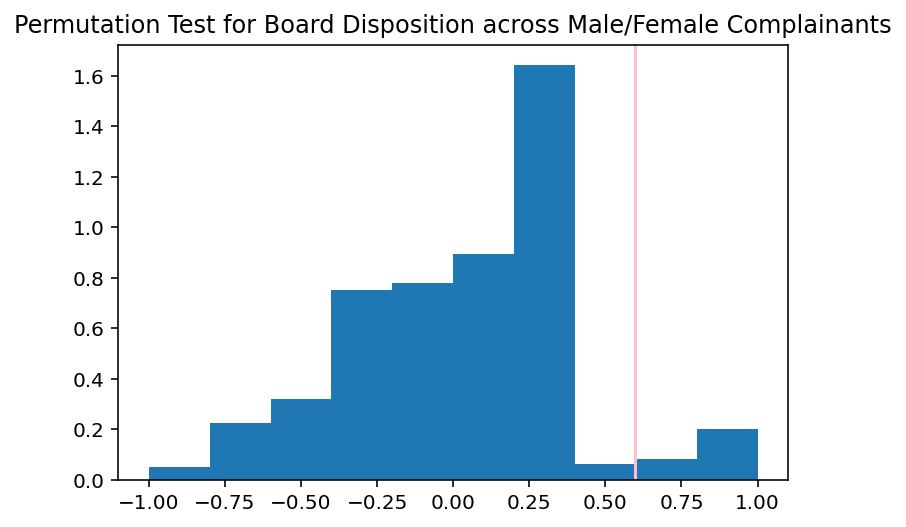

In [63]:
plt.hist(metrs, density = True)
plt.axvline(x = p_val, color = "pink")
plt.title("Permutation Test for Board Disposition across Male/Female Complainants")